In [1]:
import whisper
import wave
import contextlib
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
import random
from tqdm.notebook import tqdm

# Speaker Dataset
The dataset should consist of 22khz 16-bit PCM .wav files between 1 and 10 seconds in duration (approximately). The volume between files should be normalized. The speaker should be clearly audible with minimal background noise.

In [2]:
def get_wav_duration(fname):
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        return duration

In [21]:
dataset_directory = "./lyre/dataset/obama-full"

durations = {}
for file in os.listdir(dataset_directory):
    filename = os.fsdecode(file)
    if filename.split('.')[-1] == "wav":
        path = os.path.abspath(f"{dataset_directory}/{filename}")
        duration = get_wav_duration(path)
        durations[path] = duration
print(f"{len(durations)} samples")

6162 samples


5399 samples
total sample duration: 11:44:07.302902
selected sample duration: 8:42:43.680227
min sample duration: 2.0238095238095237
max sample duration: 11.495238095238095


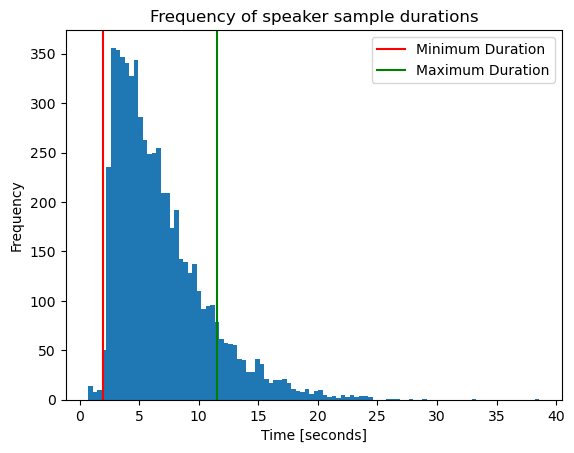

In [22]:
min_seconds = 2
max_seconds = 11.5
samples = {}
total_duration = 0
selected_duration = 0

for path, duration in durations.items():
    total_duration += duration
    if duration >= min_seconds and duration <= max_seconds:
        samples[path] = duration
        selected_duration += duration

print(f"{len(samples)} samples")
print(f"total sample duration: {str(datetime.timedelta(seconds=total_duration))}")
print(f"selected sample duration: {str(datetime.timedelta(seconds=selected_duration))}")
print(f"min sample duration: {min(samples.values())}")
print(f"max sample duration: {max(samples.values())}")

plt.hist(durations.values(), bins=100)
plt.title("Frequency of speaker sample durations")
plt.xlabel("Time [seconds]")
plt.ylabel("Frequency")
plt.axvline(x = min_seconds, color = 'r', label="Minimum Duration")
plt.axvline(x = max_seconds, color = 'g', label="Maximum Duration")
plt.legend()
plt.show()

# Transcription

In [16]:
model = whisper.load_model("medium.en")

In [17]:
# Tacotron2 character vocabulary
_pad        = '_'
_punctuation = '!\'(),.:;? '
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
_numbers = '0123456789' # technically not included in Tacotron2 but it'll get expanded during training

# Export all symbols:
symbols = set([_pad] + list(_special) + list(_punctuation) + list(_letters) + list(_numbers))

def is_in_vocab(text):
    """
    Returns True if 'text' uses ONLY the symbols defined above. Returns False otherwise.
    """
    vocab = set(text)
    return vocab.intersection(symbols) == vocab

In [18]:
transcribed_samples = {}
tossed_samples = {}

for sample in tqdm(samples.keys()):
    result = model.transcribe(sample)
    text = result["text"].strip()
    text = text.replace('"', "").replace("$", "") # try to ease some sentences back into validity
    if not is_in_vocab(text) or text[-1] not in _punctuation:
        tossed_samples[sample] = text
    else:
        transcribed_samples[sample] = text

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
samples_to_draw = 2

print(f"Accepted Samples: {len(transcribed_samples)}")
for path, text in random.sample(list(transcribed_samples.items()), samples_to_draw):
    print(f'{path}|{text}')

print(f"Tossed Samples: {len(tossed_samples)}")
for path, text in random.sample(list(tossed_samples.items()), samples_to_draw):
    print(f'{path}|{text}')

Accepted Samples: 5
/mnt/c/Users/david/source/obama-tts/lyre/dataset/test/Sound 03.wav|It was a lovely location, across from Promontory Point and Lake Michigan, with dogwood trees in the ample courtyard that bloomed a bright pink every spring.
/mnt/c/Users/david/source/obama-tts/lyre/dataset/test/Sound 04.wav|The three-bedroom apartment, laid out like a rail car from front to back, wasn't large, but it had hardwood floors and decent light and a proper dining room with walnut cabinets.
Tossed Samples: 0


ValueError: Sample larger than population or is negative

In [20]:
# split keys by percentage
train_valid_split = 0.90
nkeys = int(train_valid_split * len(transcribed_samples))
transcribed_keys = list(transcribed_samples.keys())
train_keys = transcribed_keys[:nkeys]
valid_keys = transcribed_keys[nkeys:]

# create new dicts
train_data = {k: transcribed_samples[k] for k in train_keys}
valid_data = {k: transcribed_samples[k] for k in valid_keys}

with open(f'{dataset_directory}/train_tacotron.txt', 'w') as tacotron_file, open(f'{dataset_directory}/train_waveglow.txt', 'w') as waveglow_file:
    for path, text in train_data.items():
        tacotron_file.write(f'{path}|{text}\n')
        waveglow_file.write(f'{path}\n')
print(f"wrote {len(train_data)} training samples")

with open(f'{dataset_directory}/valid_tacotron.txt', 'w') as tacotron_file, open(f'{dataset_directory}/valid_waveglow.txt', 'w') as waveglow_file:
    for path, text in valid_data.items():
        tacotron_file.write(f'{path}|{text}\n')
        waveglow_file.write(f'{path}\n')
print(f"wrote {len(valid_data)} validation samples")

wrote 4 training samples
wrote 1 validation samples
